<a href="https://colab.research.google.com/github/Thiraput01/My_ML_learning/blob/main/CNN/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [14]:
transform = transforms.ToTensor()

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [8]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [9]:
train_iter = iter(trainset)
img, label = next(train_iter)
img.shape, label

(torch.Size([1, 28, 28]), 5)

5


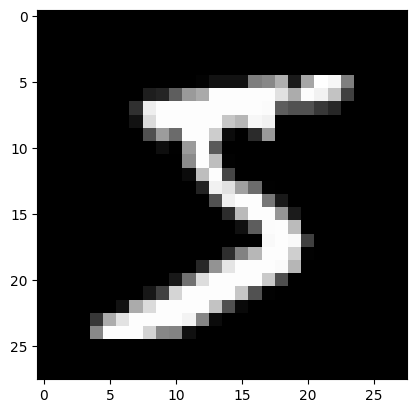

In [17]:
np_img = img.numpy()
print(classes[label])
plt.imshow(np_img.reshape(28, 28, 1), cmap="gray")

In [16]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [23]:
data_iter = iter(trainloader)
img, label = next(data_iter)
img.shape, label

(torch.Size([4, 1, 28, 28]), tensor([2, 8, 6, 8]))

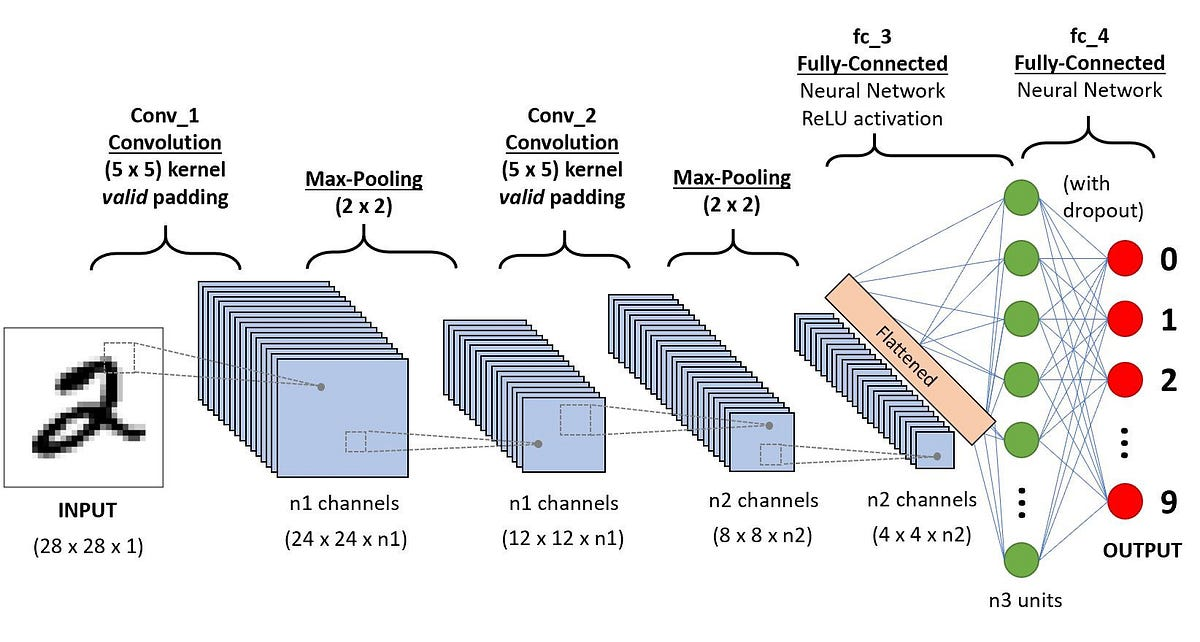



> Will implementing this model



In [45]:
class MNIST_CNN(nn.Module):

  def __init__(self):
    super().__init__()

    # first layer
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=5)
    self.pool1 = nn.MaxPool2d(2, 2)

    # second layer
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5)
    self.pool2 = nn.MaxPool2d(2, 2)

    # flatten
    self.flatten = nn.Flatten()

    # plug into FC
    self.fc3 = nn.Linear(in_features=8192, out_features=512)
    self.drop3 = nn.Dropout(0.2)
    self.fc4 = nn.Linear(in_features=512, out_features=10) # out


  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.flatten(x)

    x = self.drop3(F.relu(self.fc3(self.flatten(x))))
    x = self.fc4(x)

    return x

In [46]:
model = MNIST_CNN()
model.to(device)

MNIST_CNN(
  (conv1): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=8192, out_features=512, bias=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)

In [47]:
for i, data in enumerate(trainloader):
  inputs, labels = data[0], data[1]
  inputs, labels = inputs.to(device), labels.to(device)
  print(f'input shape: {inputs.shape}')
  print(f'after network shape: {model(inputs).shape}')
  break

input shape: torch.Size([4, 1, 28, 28])
after network shape: torch.Size([4, 10])


In [48]:
# count parameters
c = 0
for x in model.parameters():
  c += len(torch.flatten(x))
print(f'Number of parameters in the model: {c:,}')

Number of parameters in the model: 7,483,914


In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
trainloader.batch_size

4

In [57]:
def train_one_epoch():
  model.train(True)
  running_loss = 0.0
  running_accuracy = 0.0

  for batchIdx, data in enumerate(trainloader):
    print("hello, training batch:", batchIdx)
    inputs, labels = data[0].to(device), data[1].to(device)

    # reset grad
    optimizer.zero_grad()

    # run inputs throughout the network
    outputs = model(inputs) # shape: [batch_size, 10]
    corrects = torch.sum(labels == torch.argmax(outputs, dim=1)).item() # returns int in [0,8], represents howmany labels model got it right
    running_accuracy += corrects / batch_size

    # calculate loss
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # backprop
    loss.backward()
    optimizer.step()

    if batchIdx+1 % 2 == 500: # print every 500 batches
      avg_loss_across_batches = running_loss / 500
      avg_accuracy_across_batches = (running_accuracy / 500) * 100
      print(f'Batch {batchIdx+1:02}, Loss: {avg_loss_across_batches:.3f}, Accuracy: {avg_accuracy_across_batches:.1f}% ')

      running_loss = 0.0
      running_accuracy = 0.0

print()


In [54]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0
  running_accuracy = 0.0

  for i, data in enumerate(valloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    with torch.no_grad():

      outputs = model(inputs)
      corrects = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
      running_accuracy += corrects / batch_size

      loss = criterion(outputs, labels)
      running_loss += loss.item()


  avg_loss_across_batches = running_loss / len(valloader)
  avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
  print(f'Val Loss: {avg_loss_across_batches:.3f}, Val Accuracy: {avg_accuracy_across_batches:.1f}% ')

  print('*********************************************')
  print()

In [58]:
num_epochs= 2

for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}\n')

  train_one_epoch()
  validate_one_epoch()

print("finished training")

Epoch 1

hello, training batch: 0
hello, training batch: 1
hello, training batch: 2
hello, training batch: 3
hello, training batch: 4
hello, training batch: 5
hello, training batch: 6
hello, training batch: 7
hello, training batch: 8
hello, training batch: 9
hello, training batch: 10
hello, training batch: 11
hello, training batch: 12
hello, training batch: 13
hello, training batch: 14
hello, training batch: 15
hello, training batch: 16
hello, training batch: 17
hello, training batch: 18
hello, training batch: 19
hello, training batch: 20
hello, training batch: 21
hello, training batch: 22
hello, training batch: 23
hello, training batch: 24
hello, training batch: 25
hello, training batch: 26
hello, training batch: 27


KeyboardInterrupt: 

In [ ]:
def test_model():
  model.train(False)
  running_loss = 0.0
  running_accuracy = 0.0

  for i, data in enumerate(testloader):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():

      outputs = model(inputs)
      corrects = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
      running_accuracy += corrects / batch_size

      loss = criterion(outputs, labels)
      running_loss += loss.item()


  avg_loss_across_batches = running_loss / len(testloader)
  avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
  print(f'Test Loss: {avg_loss_across_batches:.3f}, Test Accuracy: {avg_accuracy_across_batches:.1f}% ')
